# WET-007: Compare CWFS approaches with WET-001 ComCam data


Owner: **Chris  Suberlak** [@suberlak](https://github.com/lsst-ts/ts_aos_analysis/issues/new?body=@suberlak) <br>
Last Verified to Run: **2024-11-05** <br>
Software Version:
  - `ts_wep`: **12.5.0**
  - `lsst_distrib`: **w_2024_44**

Use WET-001 LsstComCam data. As for LsstCam, it is a simulation of 100 random states, with intra, extra, and in-focus positions.  

## Imports 

In [3]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
import numpy as np


## Employ the central butler repository  to ingest raws,  perform ISR, and run WEP.

    butler register-instrument /sdf/data/rubin/repo/aos_imsim lsst.obs.lsst.LsstComCam 
    
    butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state_*/amp* --update-records -t direct
    
    butler write-curated-calibrations /sdf/data/rubin/repo/aos_imsim  lsst.obs.lsst.LsstComCam 
    
    butler define-visits /sdf/data/rubin/repo/aos_imsim   lsst.obs.lsst.LsstComCam


In   `/sdf/group/rubin/shared/scichris/DM-46763_WET-007`,  make `site_bps.yaml`, containing  


    site:
      s3df:
        profile:
          condor:
            +Walltime: 7200

In [15]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCam/raw/all'],
                             where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 and exposure.science_program = '1'").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

2640


We're short of 9x300 = 2700, because for some optical states not all detectors got simulated. 

Run ISR on all states:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:commissioning


    description: basic ISR
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstComCam
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        # Below we specify the configuration settings we want to use
        # when running the task in this pipeline. Since our data doesn't
        # include bias or flats we only want to use doApplyGains and
        # doOverscan in our isr task.
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: True
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'

      
    
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim -i  LSSTComCam/raw/all,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_ISR -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineISR.yaml  -d "instrument='LSSTComCam' and exposure.science_program = '1'"


In [ ]:
collection = 'WET-001_lsstComCam_ISR'
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=[collection],
                             where=f"instrument='LSSTComCam' and exposure.day_obs = 20240723").expanded()
print(len(list(dataRefs)))

We use the following pipelines: 

* TIE pipeline (`lsstComCamPipelineDonutsZernikesTIE.yaml`)

    
    
        description: run pipeline from ISR to Zk with TIE
        
        # Here we specify the corresponding instrument for the data we
        # will be using.
        instrument: lsst.obs.lsst.LsstComCam
        
        # Then we can specify each task in our pipeline by a name
        # and then specify the class name corresponding to that task
        tasks:
          generateDonutDirectDetectTask:
            class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
            config:
              donutSelector.useCustomMagLimit: True
              measurementTask.nSigmaDetection: 5
          cutOutDonutsScienceSensorGroupTask::
            class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
          calcZernikesTask:
            class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask



* Danish pipeline (`lsstComCamPipelineDonutsZernikesDanish.yaml`):

    
        description: run pipeline from ISR to Zk with Danish
        
        # Here we specify the corresponding instrument for the data we
        # will be using.
        instrument: lsst.obs.lsst.LsstComCam
        
        # Then we can specify each task in our pipeline by a name
        # and then specify the class name corresponding to that task
        tasks:
          generateDonutDirectDetectTask:
            class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
            config:
              donutSelector.useCustomMagLimit: True
              measurementTask.nSigmaDetection: 5
          cutOutDonutsScienceSensorTask::
            class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
          calcZernikesTask:
            class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
            config:
               python: |
                  from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
                  config.estimateZernikes.retarget(EstimateZernikesDanishTask)

They are run with following commands: 

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007/
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:commissioning

   
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_TIE_6001_6200_bps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesTIE.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723" 

    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_Danish_6001_6200_bps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesDanish.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723"



## Inspect the results 

In [37]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw', 
                                         collections=['WET-001_lsstComCam_TIE_6001_6200_bps']
                                        ).expanded()
print(len(list(dataRefs)))

861


Given that, plot the comparison in fit results between Danish and TIE:

In [7]:
# store all Danish vs TIE in a dictionary 
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'WET-001_lsstComCam_TIE_6001_6200_bps'
datasetRefs = list(registry.queryDatasets('zernikeEstimateAvg', collections=[output_collection],
                                     ).expanded())
seqs = np.array([int(str(ref.dataId.visit.seq_num)[1:]) for ref in datasetRefs])
states = np.unique(np.array((seqs+1) / 2).astype(int) )

results = {'tie':{}, 'danish':{}}
for method in results.keys():
    results[method] = {}
    for state in states:
        results[method][state] = {}
        for raft in range(9):
            results[method][state][raft] = {}

for ref in datasetRefs:
    # read in the results of each method 
    for method in results.keys():
        if method == 'tie':
            coll_method = 'TIE'  
        else:
            coll_method = 'Danish'
        output_collection = f'WET-001_lsstComCam_{coll_method}_6001_6200_bps'
        seq_num = int(str(ref.dataId.visit.seq_num)[1:])
        state = int((seq_num+1)/2)
        raft = ref.dataId.detector.id
        results[method][state][raft]['zernikeEstimateAvg'] =  butler.get('zernikeEstimateAvg', 
                          dataId=ref.dataId, 
                          collections=[output_collection])
        results[method][state][raft]['zernikeEstimateRaw'] =  butler.get('zernikeEstimateRaw', 
                          dataId=ref.dataId, 
                          collections=[output_collection])
        results[method][state][raft]['zernikes'] =  butler.get('zernikes', 
                          dataId=ref.dataId, 
                          collections=[output_collection])
        results[method][state][raft]['dataId'] = ref.dataId

To compare TIE vs Danish, we first plot the actual fit results for each detector for a single optical state:

In [105]:
def plot_fit(state, results):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i )
        
        for method in results.keys():
            # plot  averaged zks for danish and tie
            zkAvg = results[method][state][i]
            ax[i].plot(np.arange(4,29), zkAvg[0], marker='d', label=f'{method} ')
          
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish')

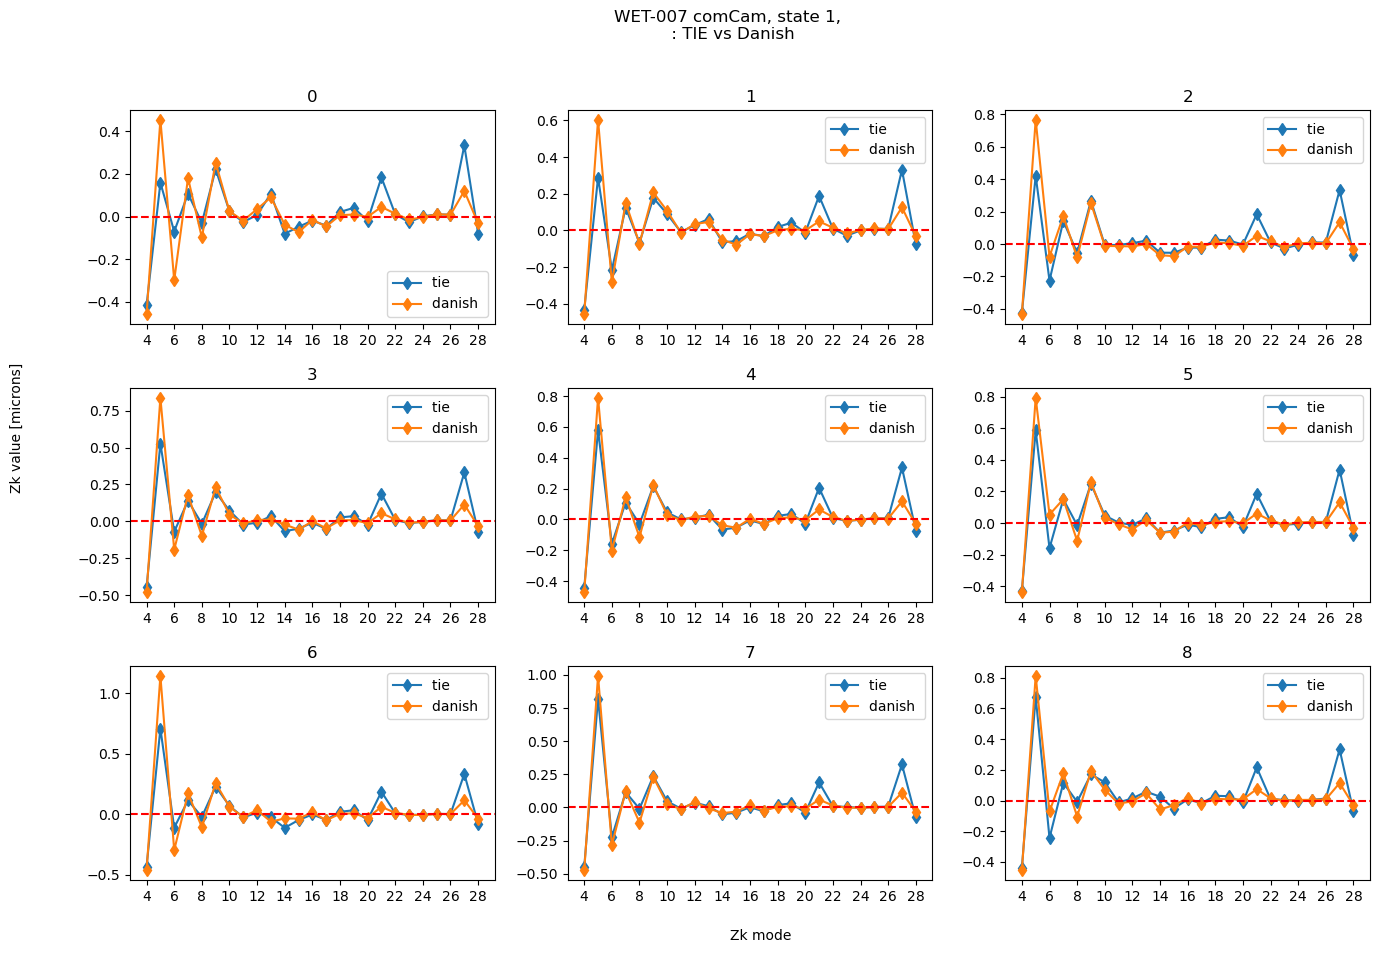

In [106]:
plot_fit(1, results)

Add information coming from scatter of individual fit results. This could be either a scatter of raw Zernike estimates per detector that got averaged,  or scatter in values of averaged Zernikes across detectors.

Illustrate first method: scatter in fit results from donuts that were accepted to contribute to the `zernikeEstimateAvg`. On the figure below the average result (solid green line) is an aggregate (median) of individual estimates from all selected donut pairs  per  exposure. We use the standard deviation of the scatter per mode as one possible proxy for the measurement uncertainty. 


In [ ]:
zkr = butler.get('zernikeEstimateRaw', dataId=ref.dataId,   collections=[output_collection])
zka = butler.get('zernikeEstimateAvg', dataId=ref.dataId,   collections=[output_collection])
zks = butler.get('zernikes', dataId=ref.dataId,    collections=[output_collection])
mask_used = zks['used'][1:]
zkr_used = zkr[mask_used]

plt.plot(np.arange(4,29), zka[0])
plt.errorbar(np.arange(4, 29), zka[0], yerr=np.std(zkr_used, axis=0), ls="--", c="C2", label="TIE", capsize=4)
for i in range(len(zkr_used)):
    plt.plot(np.arange(4,29), zkr_used[i], alpha=0.2,c='grey')
plt.xlabel('Zk mode')
plt.ylabel('Fit [microns]')
plt.title(f'Optical state {state}, detector {raft}, {coll_method}')


We plot that for all detectors for a single state, to show that  the two methods have yield very similar results:

In [147]:
def plot_fit_errorbar(state, results):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i )
        
        for method in results.keys():
            # plot  averaged zks for danish and tie
            zkAvg = results[method][state][i]['zernikeEstimateAvg']
            zkRaw = results[method][state][i]['zernikeEstimateRaw']
            zks = results[method][state][i]['zernikes']
            mask_used = zks['used'][1:]
            zkr_used = zkRaw[mask_used]
            
            #ax[i].plot(np.arange(4,29), zkAvg[0], marker='d', label=f'{method} ')
            ax[i].errorbar(np.arange(4, 29), zkAvg[0], yerr=np.std(zkr_used, axis=0), 
                          label=f'{method} ', capsize=4)
            
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish')

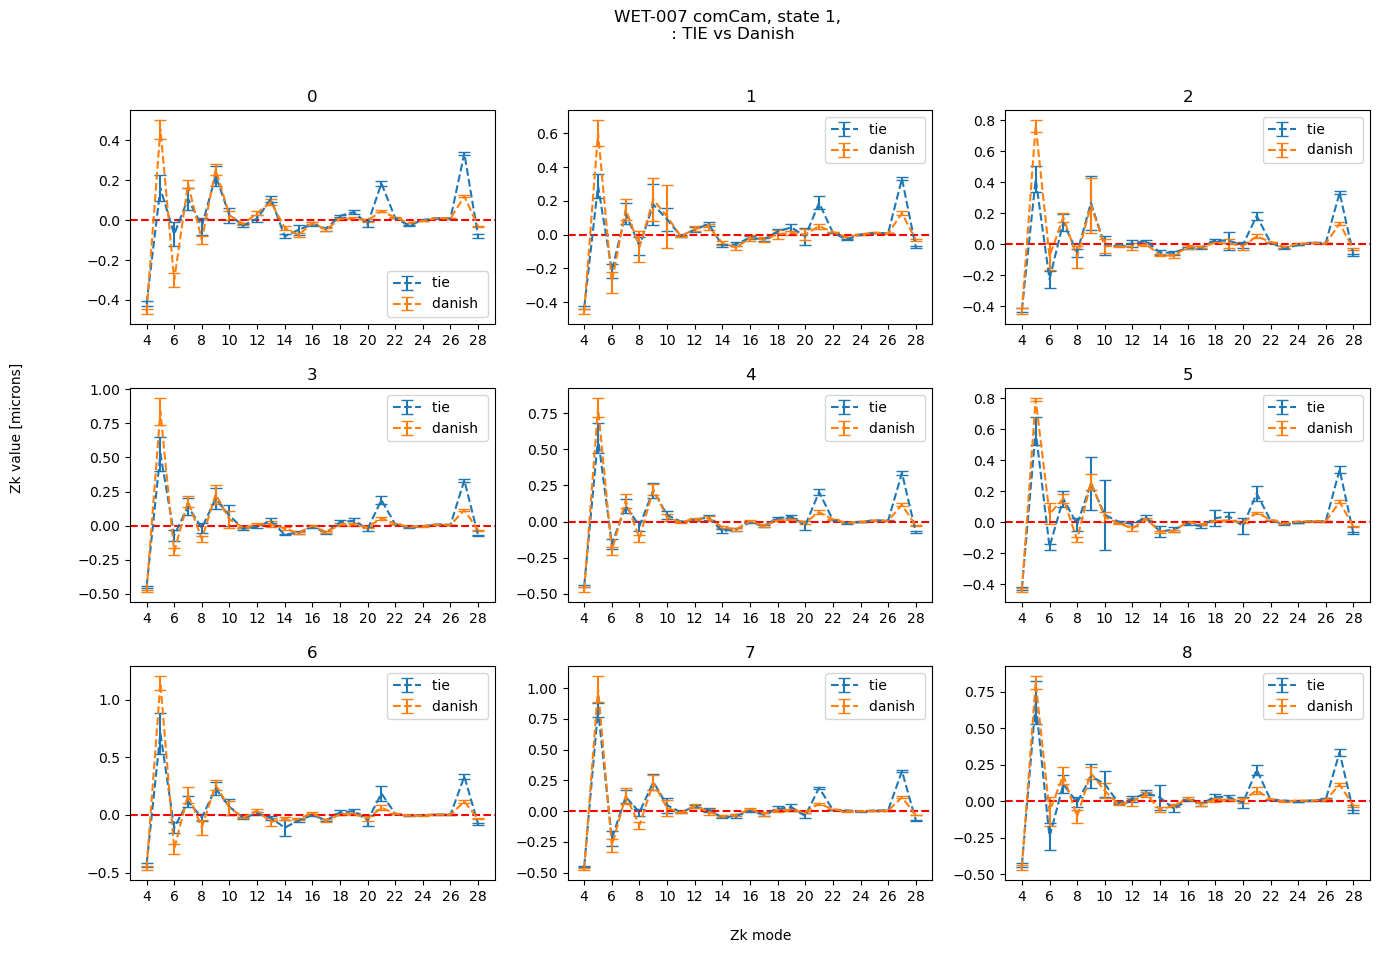

In [148]:
plot_fit_errorbar(1, results)

Illustrate the difference between the two methods:

In [111]:
def plot_diff(state, results):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i )
    
        # plot  difference for danish and tie
        zk1 = results['danish'][state][i][0]
        zk2 = results['tie'][state][i][0]
        ax[i].plot(np.arange(4,29),zk1-zk2, marker='d', label=f'{method} ')
      
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        #ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, f'$\Delta$ zk fit (Danish-TIE) [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish')

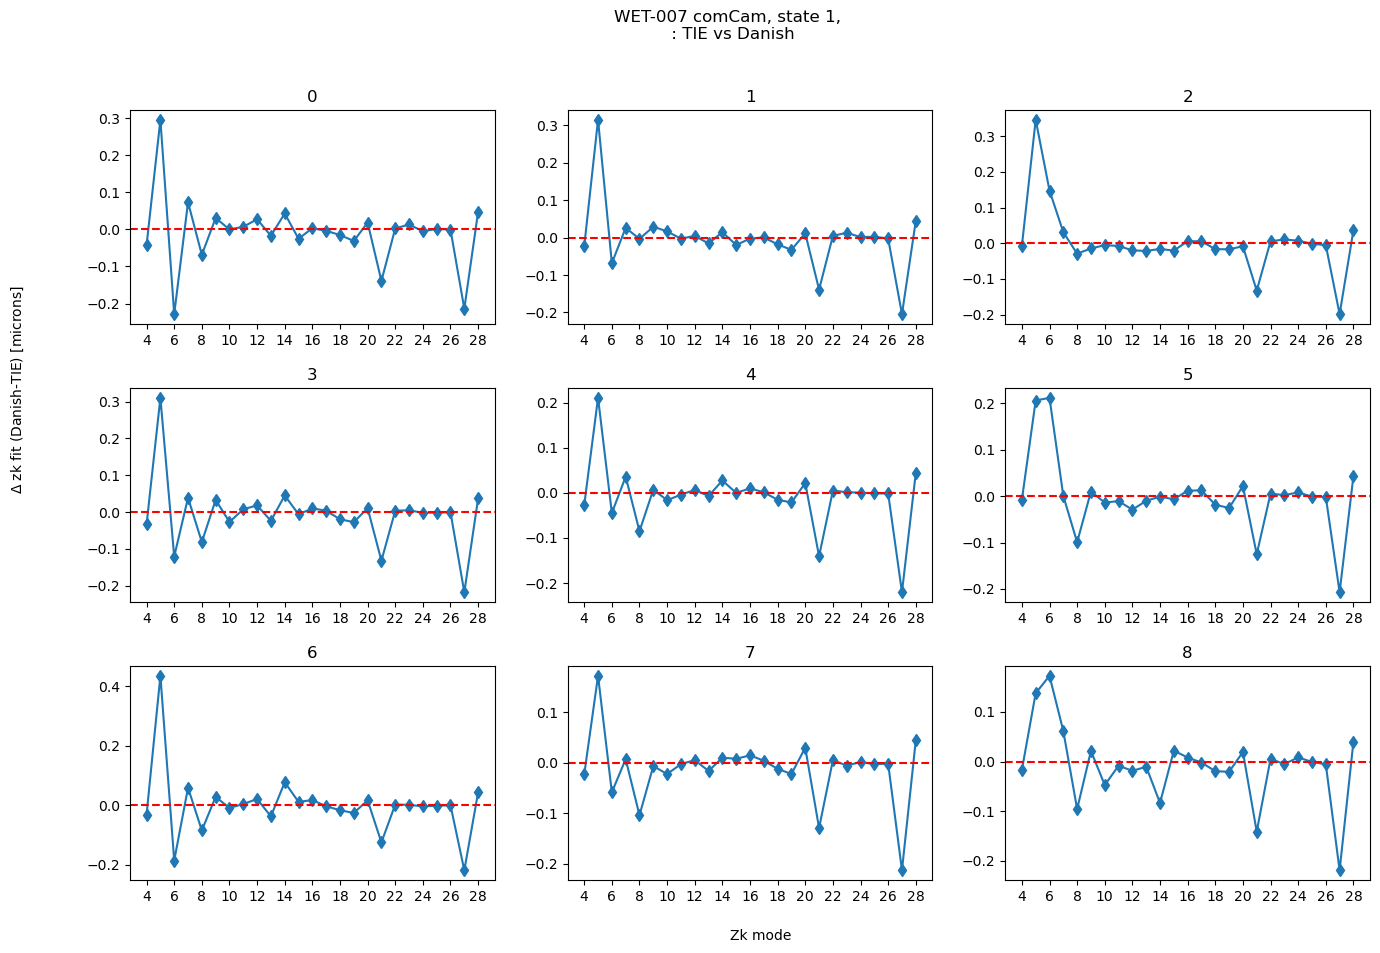

In [112]:
plot_diff(1, results)

In [ ]:
Calculate the RMS difference between TIE and Danish per detector per state: 

In [197]:
rmss={}
states = {}
rmserrDanish = {}
rmserrTie = {}

sumErrDanish  = {}
sumErrTie = {}
for raft in range(9):
   rmss[raft] = []
   states[raft] = [] 
   rmserrDanish[raft] = []
   rmserrTie[raft] = []
   sumErrDanish[raft] = []
   sumErrTie[raft]=[]
   for state in range(1,101):
        #print(raft, state)
        cond1 = len(results['danish'][state][raft])>1
        cond2 = len(results['tie'][state][raft])>1
        if cond1 and cond2 : 
            # calculate RMS difference between two estimates of Zk fits 
            zk1 = results['danish'][state][raft]['zernikeEstimateAvg'][0]
            zk2 = results['tie'][state][raft]['zernikeEstimateAvg'][0]
            rms_diff =  np.sqrt(np.mean(np.square(zk1-zk2)))
            rmss[raft].append(rms_diff)
            states[raft].append(state)

            # calculate RMS of uncertainties 
            for method, rmsDict, sumDict in zip(['danish', 'tie'],
                                       [rmserrDanish, rmserrTie],
                                        [sumErrDanish, sumErrTie]
                                      ):
                zkRaw = results[method][state][raft]['zernikeEstimateRaw']
                zks = results[method][state][raft]['zernikes']
                mask_used = zks['used'][1:]
                zkr_used = zkRaw[mask_used]
                zkErr = np.std(zkr_used, axis=0) # uncertainty per Zk mode
                rmsErr = np.sqrt(np.mean(np.square(zkErr))) # single number 
                rmsDict[raft].append(rmsErr) 
                sumDict[raft].append(np.sqrt(np.sum(np.square(zkErr)))) 

            if rms_diff > 10:
                print(method, raft, state, rms_diff)

tie 1 45 608.7696423542536


The total error per detector per state is the sum of variances. This is done for Danish and TIE:

$$
\sigma_{ttl}^{2} = \sum_{i=4}^{i=28}{\sigma_{i}^{2}}
$$

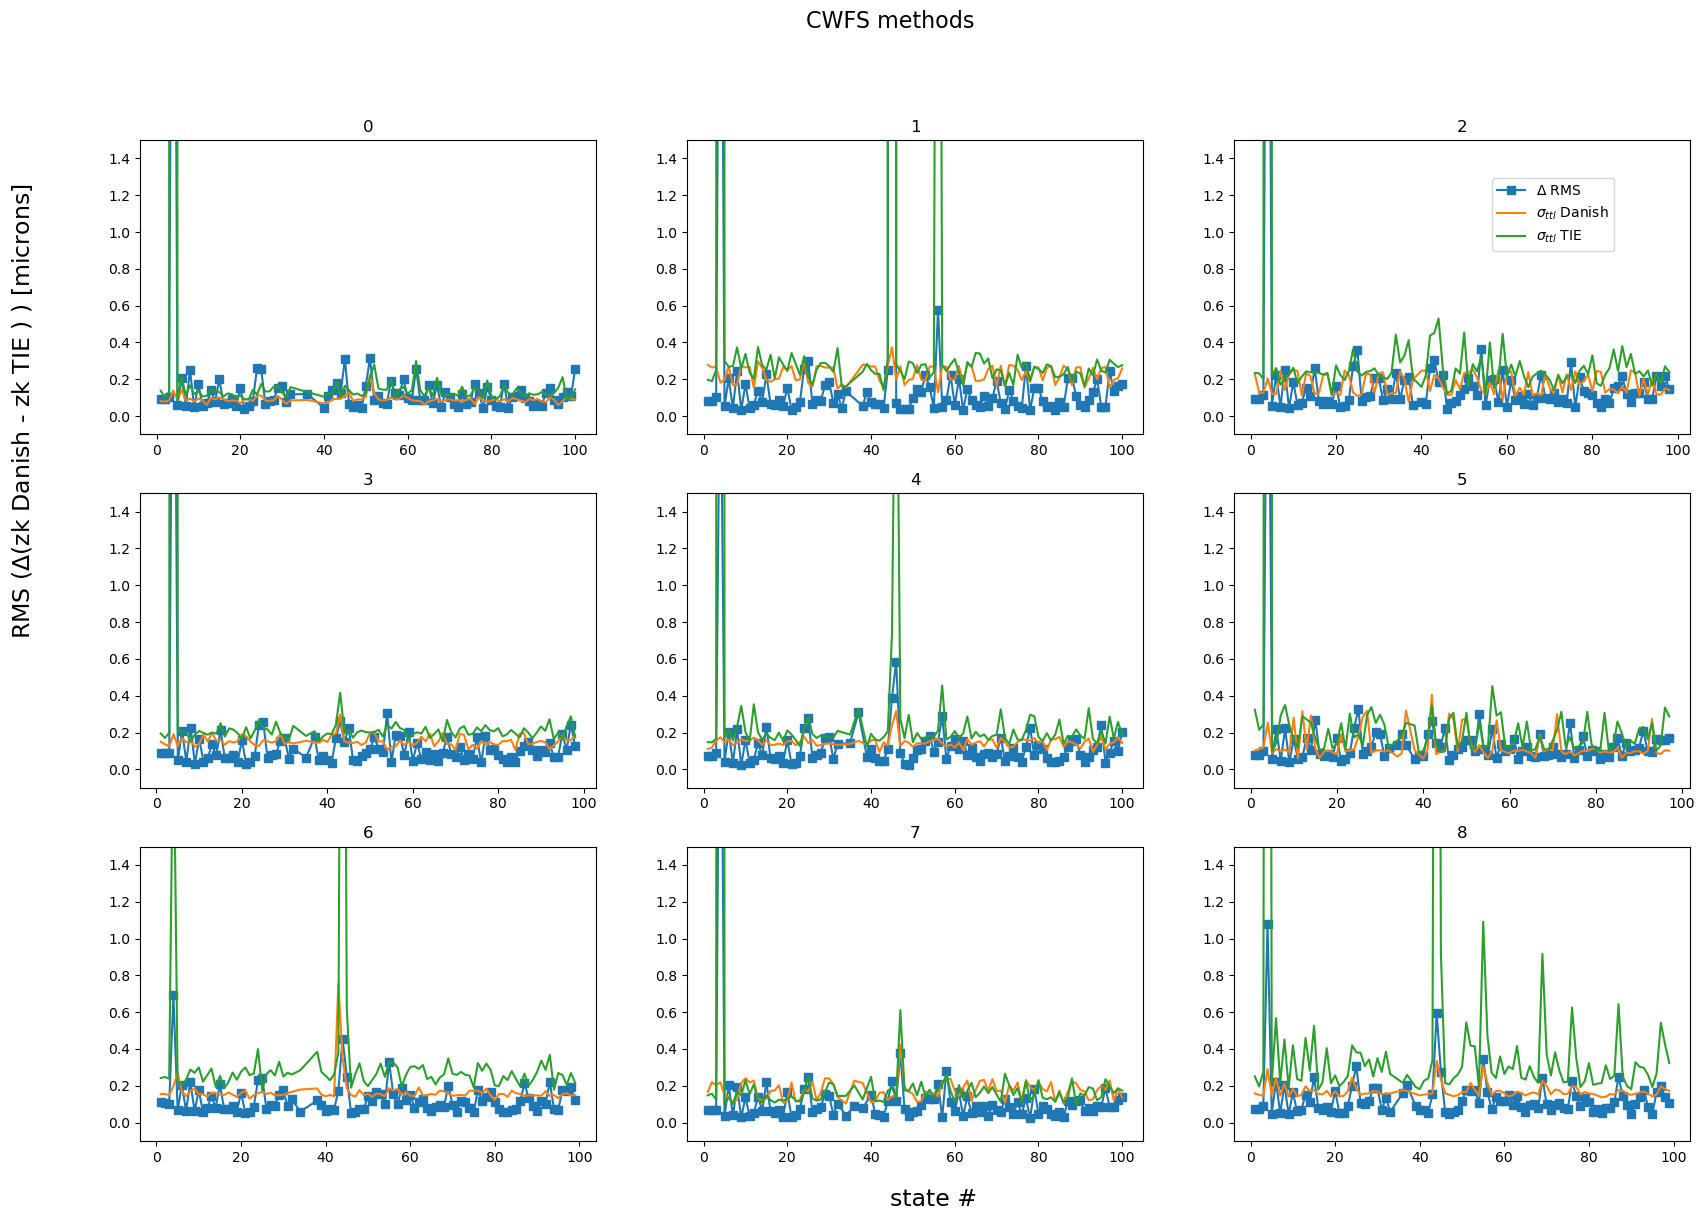

In [203]:
fig,axs = plt.subplots(3,3,figsize=(20,13))
ax = np.ravel(axs)

for raft in range(9):
    ax[raft].plot(states[raft], rmss[raft], marker='s', label=r'$\Delta$ RMS')
    ax[raft].plot(states[raft], sumErrDanish[raft], label=r'$\sigma_{ttl}$ Danish') 
    ax[raft].plot(states[raft], sumErrTie[raft], label=r'$\sigma_{ttl}$ TIE') 
    #ax[raft].plot(states[raft], rmserrDanish[raft], label='RMS err Danish')
    #ax[raft].plot(states[raft], rmserrTie[raft], label='RMS err TIE')
    #ax[
    ax[raft].set_title(raft)
    ax[raft].set_ylim(-0.1,1.5)
   
fig.text(0.5,0.06,'state #', fontsize=17)
fig.text(0.06,0.5,r'RMS ($\Delta$(zk Danish - zk TIE ) ) [microns] ', rotation=90, fontsize=17)
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

For most simulated states, the agreement is at 0.1 microns rms. Inspect those which have a large TIE error (that also corresponds to largest difference in fit results).

Which state has such high error for TIE in raft 0? 

In [194]:
raft = 0
np.array(states[raft])[np.array(rmserrTie[raft]) > 0.5]

array([4])

Plot in detail this state: 

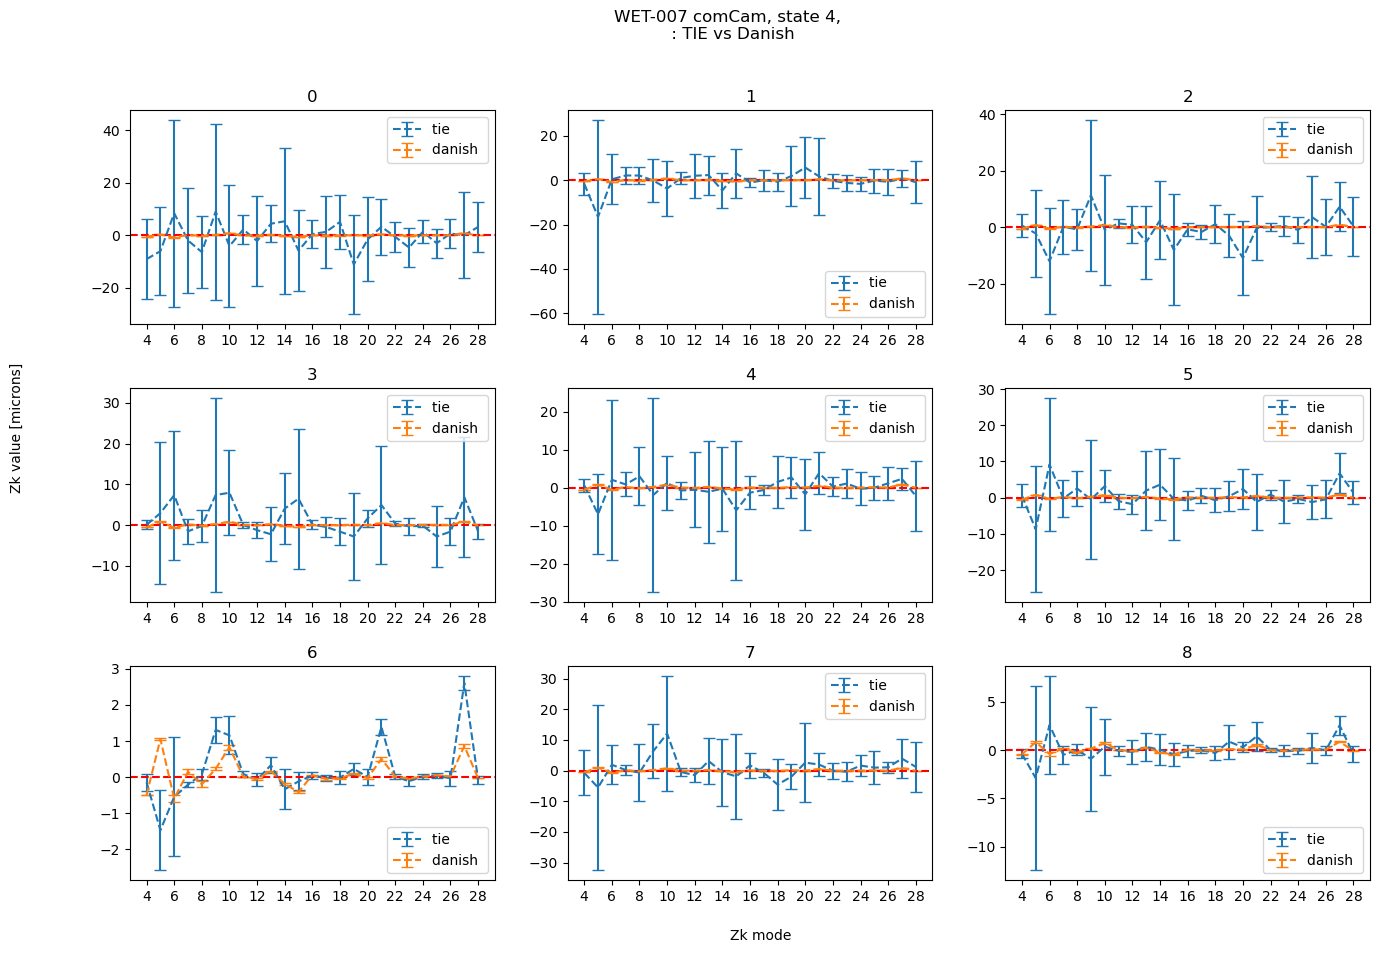

In [195]:
plot_fit_errorbar(4, results)

Plot donut stamps for that state:

In [6]:
state=4
results['tie'][state][0]['dataId']

NameError: name 'results' is not defined

In [5]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'WET-001_lsstComCam_TIE_6001_6200_bps'

donutStampsExtra = butler.get('donutStampsExtra', collections=[output_collection],
                              dataId=results['tie'][state][0]['dataId']
                             )

NameError: name 'results' is not defined

In [240]:
len(donutStampsExtra)

52

NameError: name 'donutStampsExtra' is not defined

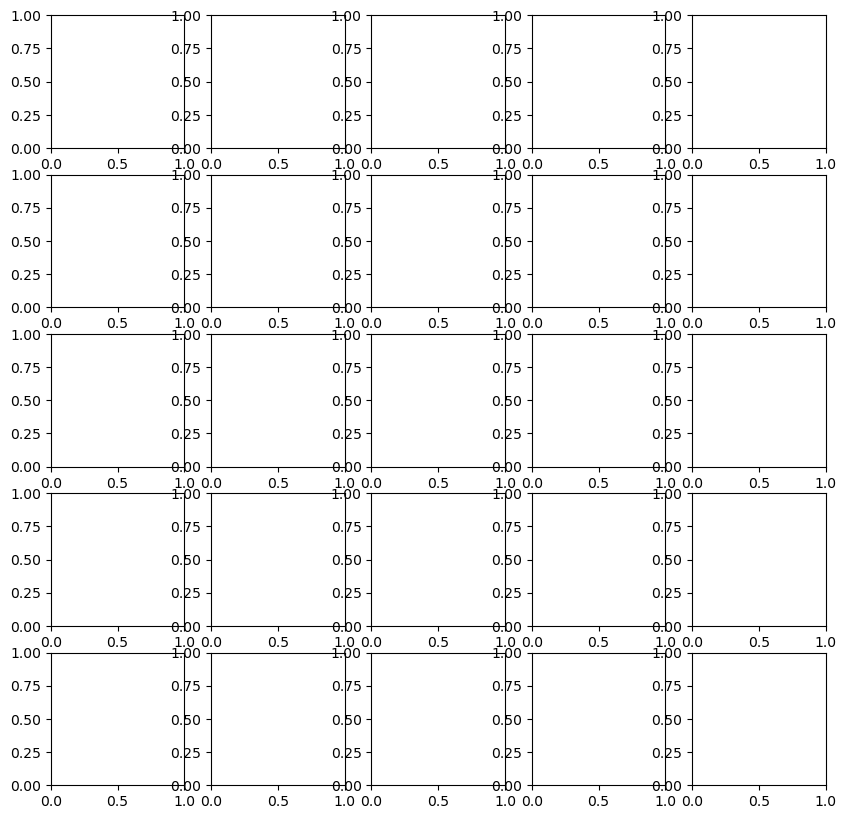

In [4]:
fig,axs = plt.subplots(5,5, figsize=(10,10))
ax = np.ravel(axs)
i=0
donutStamps = donutStampsExtra
for stamp in donutStamps:
    if i < len(ax):
        ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
        i += 1 
if len(donutStamps)<len(ax):
    for i in range(len(donutStamps), len(ax)):
        ax[i].axis('off')

We see that the main disagreement corresponds to very heavily distorted donuts where TIE essentially fails. In such cases it would be recommended to run Danish as  well as it may yield more constrained results. 

In [1]:
import os
os.environ["no_proxy"] += ",.consdb"
from lsst.summit.utils import ConsDbClient
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
print(f'schemas:\n', client.schema())

schemas:
 ['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim']


In [302]:
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
print(client.schema())  # list the instruments
print(client.schema('latiss'))  # list tables for an instrument
print(client.schema('latiss', 'cdb_latiss.exposure'))

['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim']
['cdb_latiss.ccdvisit1_quicklook', 'cdb_latiss.ccdexposure', 'cdb_latiss.exposure', 'cdb_latiss.exposure_flexdata', 'cdb_latiss.exposure_flexdata_schema', 'cdb_latiss.visit1_quicklook', 'cdb_latiss.ccdexposure_flexdata', 'cdb_latiss.ccdexposure_flexdata_schema', 'cdb_latiss.ccdexposure_camera']
{'exposure_id': ('BIGINT', 'None'), 'exposure_name': ('VARCHAR(20)', 'None'), 'controller': ('VARCHAR(1)', 'None'), 'day_obs': ('INTEGER', 'None'), 'seq_num': ('INTEGER', 'None'), 'physical_filter': ('VARCHAR(32)', 'None'), 'band': ('VARCHAR(32)', 'None'), 's_ra': ('DOUBLE PRECISION', 'None'), 's_dec': ('DOUBLE PRECISION', 'None'), 'sky_rotation': ('DOUBLE PRECISION', 'None'), 'azimuth_start': ('DOUBLE PRECISION', 'None'), 'azimuth_end': ('DOUBLE PRECISION', 'None'), 'azimuth': ('DOUBLE PRECISION', 'None'), 'altitude_start': ('DOUBLE PRECISION', 'None'), 'altitude_end': ('DOUBLE PRECISION', 'None'), 'altitude': ('DOUBLE PRECISION

In [303]:
data = client.query('SELECT dome_azimuth from cdb_latiss.exposure where day_obs = 20240530 and seq_num = 592')
data

HTTPError: 500 Server Error: Internal Server Error for url: http://@consdb-pq.consdb/consdb/query

In [297]:
schema = 'lsstcomcam'

In [298]:
table = 'exposure'

In [299]:
print(f'tables (schema={schema}):\n', client.schema(schema))

tables (schema=lsstcomcam):
 ['cdb_lsstcomcam.exposure', 'cdb_lsstcomcam.ccdexposure', 'cdb_lsstcomcam.ccdexposure_flexdata', 'cdb_lsstcomcam.ccdexposure_flexdata_schema', 'cdb_lsstcomcam.ccdvisit1_quicklook', 'cdb_lsstcomcam.visit1_quicklook', 'cdb_lsstcomcam.ccdexposure_camera', 'cdb_lsstcomcam.exposure_flexdata', 'cdb_lsstcomcam.exposure_flexdata_schema']


In [300]:
print(f'columns (table={table}): {table} \n',
      list(client.schema('lsstcomcam', f'cdb_{schema}.{table}').keys()
          )
      )

columns (table=exposure): exposure 
 ['exposure_id', 'exposure_name', 'controller', 'day_obs', 'seq_num', 'physical_filter', 'band', 's_ra', 's_dec', 'sky_rotation', 'azimuth_start', 'azimuth_end', 'azimuth', 'altitude_start', 'altitude_end', 'altitude', 'zenith_distance_start', 'zenith_distance_end', 'zenith_distance', 'airmass', 'exp_midpt', 'exp_midpt_mjd', 'obs_start', 'obs_start_mjd', 'obs_end', 'obs_end_mjd', 'exp_time', 'shut_time', 'dark_time', 'group_id', 'cur_index', 'max_index', 'img_type', 'emulated', 'science_program', 'observation_reason', 'target_name', 'air_temp', 'pressure', 'humidity', 'wind_speed', 'wind_dir', 'dimm_seeing', 'focus_z', 'simulated', 's_region', 'vignette', 'vignette_min']


In [301]:
data = client.query('SELECT dome_azimuth from cdb_latiss.exposure where day_obs = 20240530 and seq_num = 592')
data

HTTPError: 500 Server Error: Internal Server Error for url: http://@consdb-pq.consdb/consdb/query

In [294]:
day_obs = 20241025
query = f"""
SELECT e.band, e.exp_time, q.* 
from cdb_lsstcomcam.visit1_quicklook q, cdb_lsstcomcam.exposure e
where q.visit_id = e.exposure_id
and e.day_obs = {day_obs}
--order by e.seq_num desc
"""
df = client.query(query)
#df.columns
#df[['visit_id', 'eff_time_median', 'eff_time_sky_bg_scale_median', 'eff_time_psf_sigma_scale_median', 'eff_time_zero_point_scale_median']]
df[['visit_id', 'band', 'psf_sigma_median', 'sky_bg_median', 'zero_point_median']]

HTTPError: 500 Server Error: Internal Server Error for url: http://@consdb-pq.consdb/consdb/query

In [286]:
query = f"""
SELECT e.exposure_id, e.band, e.exp_time, q.* 
from cdb_lsstcomcam.visit1_quicklook q, cdb_lsstcomcam.exposure e
where q.visit_id = e.exposure_id
and e.day_obs = 20241028
--order by e.seq_num desc
"""
df = client.query(query)

HTTPError: 500 Server Error: Internal Server Error for url: http://@consdb-pq.consdb/consdb/query

In [271]:
schema = 'lsstcomcam'

In [272]:
table = 'exposure'

HTTPError: 503 Server Error: Service Unavailable for url: http://@consdb-pq.consdb/consdb/schema

## Get the rotator angle for LsstComCam image with scatter light 

In [209]:
# butler = Butler('/repo/embargo',collections=['LSSTComCam/defaults'])   <- this onlyhas raws.  

# dataRefs = list(butler.registry.queryDatasets('quickLookExp', where="instrument='LSSTComCam' and \
# exposure.observation_type='cwfs' ").expanded())

In [254]:
repo = 'embargo_new'
collection = 'LSSTComCam/nightlyValidation'
butler = Butler(repo, collections=[collection])
#dataRefs = list(butler.registry.queryDatasets('postISRCCD', where="instrument='LSSTComCam' and \
#exposure.observation_type='cwfs' and day_obs = 20241029 and exposure.seq_num = 123").expanded())

dataRefs = list(butler.registry.queryDatasets('postISRCCD', where="instrument='LSSTComCam' and \
exposure.observation_type='cwfs' and day_obs = 20241030 and exposure.seq_num = 72").expanded())

In [263]:
dataRefs[0].dataId.detector

detector.RecordClass(instrument='LSSTComCam', id=0, full_name='R22_S00', name_in_raft='S00', raft='R22', purpose='SCIENCE')

In [265]:
dataRefs[0].dataId.exposure.sky_angle

330.53306461575716

In [255]:
resource = butler.getURI(dataRefs[0])

In [256]:
fs, path =  resource.to_fsspec()

In [257]:
fs

In [258]:
path

'rubin-summit-users/LSSTComCam/nightlyValidation/2/postISRCCD/20241030/CC_O_20241030_000072/postISRCCD_LSSTComCam_r_03_CC_O_20241030_000072_R22_S00_LSSTComCam_nightlyValidation_2.fits'

In [260]:
with fs.open(path) as f, fits.open(f) as fits_obj:
    hdr = fits_obj[0].header
    data = fits_obj[1].data
    for key in hdr.keys():
        if key.startswith('ROT'):
            print(key, hdr[key])

ROTPA 330.533064615757
ROTCOORD sky
ROTTYPE SKY


ROTPA 316.389273347567
ROTCOORD sky
ROTTYPE SKY


In [ ]:
fits.open

In [ ]:
from lsst.resources import ResourcePath
import astropy.io.fits as fits

# Stuff

url = series["url"][0].replace("https://s3.cp.lsst.org/", "s3://lfa@")
resource = ResourcePath(url)
fs, path = resource.to_fsspec()
with fs.open(path) as f, fits.open(f) as fits_obj:
    hdr = fits_obj[0].header
    data = fits_obj[1].data

In [221]:
#len(dataRefs)

9

In [226]:
dataRefs[0].dataId.exposure

exposure.RecordClass(instrument='LSSTComCam', id=2024102900123, day_obs=20241029, group='2024-10-30T05:32:25.750#6', physical_filter='r_03', obs_id='CC_O_20241029_000123', exposure_time=30.0, dark_time=30.4452, observation_type='cwfs', observation_reason='intra_sensitivity_m2_dx', seq_num=123, seq_start=123, seq_end=123, target_name='UNKNOWN', science_program='BLOCK-T64', tracking_ra=65.63586919921833, tracking_dec=-54.080527509345906, sky_angle=316.3892733475666, azimuth=165.13403388407, zenith_angle=24.960321116083904, has_simulated=False, can_see_sky=True, timespan=Timespan(begin=astropy.time.Time(2460614.0, -0.25829615723341437, scale='tai', format='jd'), end=astropy.time.Time(2460614.0, -0.25794378472222224, scale='tai', format='jd')))

In [229]:
span = dataRefs[0].dataId.exposure.timespan

In [232]:
span.begin.utc

<Time object: scale='utc' format='jd' value=2460613.741275602>

In [234]:
span.end.utc

<Time object: scale='utc' format='jd' value=2460613.7416279744>

In [227]:
from astropy.time import Time, TimeDelta
import pandas as pd
from lsst_efd_client import EfdClient
efd_client = EfdClient('usdf_efd')
end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                          '*', span.begin.utc, span.end.utc)


In [235]:
from lsst.summit.utils import ConsDbClient
from lsst.summit.utils.utils import computeCcdExposureId

client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
schema = 'lsstcomcam'
table = 'ccdvisit1_quicklook'
print(f'schemas:\n', client.schema())  # list the instruments
print(f'tables (schema={schema}):\n', client.schema(schema))  # list tables for an instrument
print(f'columns (table={table}): {table}\n', list(client.schema('lsstcomcam', f'cdb_{schema}.{table}').keys()))

HTTPError: 503 Server Error: Service Unavailable for url: http://@consdb-pq.consdb/consdb/schema

In [212]:


# One in particular that has a "nice" ghost
exp = butler.get('postISRCCD', dataId={'instrument': 'LSSTComCam', 'detector': 8, 'exposure': 2024102400126})

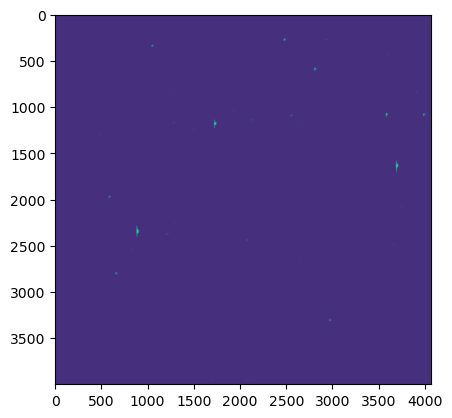

In [214]:
plt.imshow(exp.image.array)

In [ ]:
Seems that all staes 

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
for i in range(len(ax)):
    
    for visit in results['danish'].keys():
        danishFit = results['danish'][visit][i]['zernikeEstimateAvg'][0] 
        tieFit = results['tie'][visit][i]['zernikeEstimateAvg'][0] 
        diff = danishFit-tieFit   
        ax[i].plot(np.arange(4,29), diff, ls='-.', alpha=0.5, label=visit)
    ax[i].set_xticks(range(4,29,4))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, cwfs visits, range {min(visits)}:{max(visits)}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, f'$\Delta$ zk fit (Danish-TIE) [microns]', rotation='vertical')

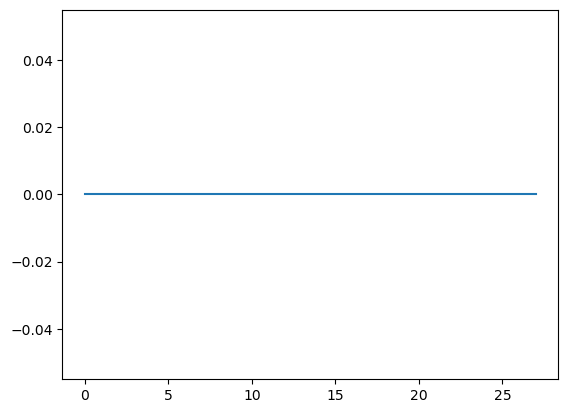

In [14]:
plt.plot(opd_zks_1_28)

Are the stamps there too ? 

In [2]:
#from lsst.daf import butler as dafButler
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
import numpy as np

# Here there were 4 seqNums, but 2 intra/extra pairs.,
# so 2x9 = 18 which is exactly what we have  , keyed with 5024072306001 and 5024072306003
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutStampsIntra', 
                                         collections=['WET-001_lsstComCam_TIE_6001_6200_bps']
                                         #collections=['WET-001_lsstComCam_TIE_6001_6004_bps'],
                                         
                                         #collections=['WET-001_lsstComCam_TIE_6001_6002_bps'],
                                        ).expanded()
print(len(list(dataRefs)))
#for ref in dataRefs:
#    print(ref)


861


In [4]:
ref = list(dataRefs)[0]

In [6]:
zk = butler.get('zernikeEstimateRaw', dataId=ref.dataId,
               collections=['WET-001_lsstComCam_TIE_6001_6200_bps']
               )

In [8]:
#zk

Run it this way just for two seqNums to see what's going on ...

run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'" --register-dataset-types


    pipetask run -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_Danish_6001_6002_1  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesDanish.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723 and exposure.seq_num in (6001..6002) and detector.id=0"


--> this works just fine! 

\====



Can I add just `aggregateZernikeTablesTask: lsst.donut.viz.AggregateZernikeTablesTask` ? 


Try: 

    pipetask run -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_Danish_6001_6002_1_agg  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesDanish.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723 and exposure.seq_num in (6001..6002) and detector.id=0"

--> runs through,  but there's no `aggregateZernikesAvg` to look at ... 

========


Try adding 

    cutOutDonutsScienceSensorGroupTask:
        class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
        config:
          python: |
            from lsst.ts.wep.task.pairTask import GroupPairer
            config.pairer.retarget(GroupPairer)


    pipetask run -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_Danish_6001_6002_1_agg_grp  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesDanishGrp.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723 and exposure.seq_num in (6001..6002) and detector.id=0"


--> does nothing! For that reason,  just run the pipeline to get to `zernikeEstimateRaw` ... 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import astropy.units as u
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = Butler(butlerRootPath)


In [18]:
dataRefs = butler.registry.queryDatasets('donutStampsIntra', 
                                         collections=['WET-001_lsstComCam_Danish_6001_6002_1'],
                                        ).expanded()
print(len(list(dataRefs)))
for ref in dataRefs:
    print(ref)

1
donutStampsIntra@{instrument: 'LSSTComCam', detector: 0, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=StampsBase] (run=WET-001_lsstComCam_Danish_6001_6002_1/20241030T180657Z id=b2e2f5fb-24c9-4a2d-b397-d8318a95f7e0)


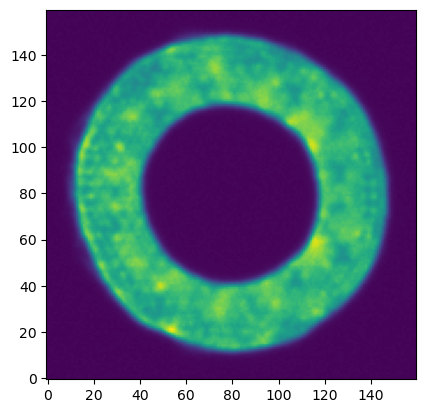

In [21]:
donutStampsIntra = butler.get('donutStampsIntra', dataId = ref.dataId, collections=['WET-001_lsstComCam_Danish_6001_6002_1'])
plt.imshow(donutStampsIntra[0].stamp_im.image.array, origin='lower')

In [22]:
dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw', 
                                         collections=['WET-001_lsstComCam_Danish_6001_6002_1'],
                                        ).expanded()
print(len(list(dataRefs)))
for ref in dataRefs:
    print(ref)

1
zernikeEstimateRaw@{instrument: 'LSSTComCam', detector: 0, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=NumpyArray] (run=WET-001_lsstComCam_Danish_6001_6002_1/20241030T180657Z id=3d9b6865-67f3-4fa2-8467-afaad1c5cb9b)


In [36]:
zks = butler.get('zernikeEstimateAvg', dataId=ref.dataId, collections=['WET-001_lsstComCam_Danish_6001_6002_1']
                )

In [38]:
#zks

In [32]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('zernikes', 
                                         collections=['WET-001_lsstComCam_Danish_6001_6002_1_agg'],
                                        ).expanded()
print(len(list(dataRefs)))
for ref in dataRefs:
    print(ref)

1
zernikes@{instrument: 'LSSTComCam', detector: 0, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=AstropyQTable] (run=WET-001_lsstComCam_Danish_6001_6002_1_agg/20241030T182301Z id=cbff0371-c733-4b11-b7a4-776b87e05256)


In [34]:
zk = butler.get('zernikes', dataId=ref.dataId, 
                collections=['WET-001_lsstComCam_Danish_6001_6002_1_agg'],)


In [35]:
zk

label,used,"intra_field [x, y]","extra_field [x, y]","intra_centroid [x, y]","extra_centroid [x, y]",intra_mag,extra_mag,intra_sn,extra_sn,intra_entropy,extra_entropy,intra_frac_bad_pix,extra_frac_bad_pix,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28
,,deg,deg,pix,pix,,,,,,,,,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm
str7,bool,"(float32, float32)","(float32, float32)","(float32, float32)","(float32, float32)",float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
average,True,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",nan,nan,nan,nan,nan,nan,0.0,0.0,-459.3310852050781,455.72149658203125,-299.64208984375,180.696533203125,-97.98578643798828,253.07228088378906,24.28363800048828,-19.200956344604492,35.06612014770508,90.04843139648438,-38.238155364990234,-74.07313537597656,-16.069284439086914,-46.862274169921875,6.150755405426025,9.417940139770508,-1.5431246757507324,45.144840240478516,13.118109703063965,-13.672309875488281,-3.896787405014038,10.871501922607422,8.24843978881836,120.17826843261719,-32.254737854003906
pair1,True,"(-0.17022648, -0.24019705)","(-0.1699486, -0.24125414)","(3201., 1907.)","(3206., 1888.)",nan,nan,7047.4,7256.893,1.0800531,0.8972684,0.0,0.0,-467.6807861328125,453.4314270019531,-321.3668518066406,174.15628051757812,-97.61566162109375,275.7071838378906,38.7852668762207,-17.169713973999023,37.63481903076172,84.61373901367188,-33.14020538330078,-77.71855926513672,-16.315052032470703,-41.42829132080078,5.1454925537109375,2.7951724529266357,-0.9342767596244812,41.04659652709961,14.288531303405762,-13.578149795532227,-1.5432178974151611,12.204594612121582,6.396724700927734,111.92703247070312,-28.20096206665039
pair2,True,"(-0.18651697, -0.2018677)","(-0.18623908, -0.2029803)","(2908., 2596.)","(2913., 2576.)",nan,nan,5093.6553,5224.389,1.7063274,1.39257,0.0,0.0,-463.4400939941406,482.7894592285156,-292.2415771484375,172.3900146484375,-94.87638854980469,260.36279296875,27.77961540222168,-16.743925094604492,32.550323486328125,79.94074249267578,-32.9124755859375,-71.48381042480469,-14.14881420135498,-42.4415283203125,5.7320075035095215,6.217524528503418,-0.4823889136314392,43.498374938964844,13.798850059509277,-13.158413887023926,-3.2471506595611572,10.668045997619629,6.821978569030762,113.865234375,-29.56562042236328
pair3,True,"(-0.15574905, -0.16826236)","(-0.15547112, -0.16943042)","(3461., 3200.)","(3466., 3179.)",nan,nan,3646.8284,3735.362,2.5068417,2.1322181,0.0,0.0,-470.7565002441406,534.2730102539062,-283.908935546875,181.02159118652344,-110.57537841796875,190.1638641357422,6.865633487701416,-12.581404685974121,30.746423721313477,66.73287200927734,-36.05323791503906,-61.66685485839844,-9.959357261657715,-43.67570495605469,9.873201370239258,12.691904067993164,3.5859999656677246,39.03526306152344,14.376917839050293,-12.352643013000488,-2.817227840423584,10.231449127197266,6.8489484786987305,116.52629852294922,-33.49528884887695
pair4,True,"(-0.15442725, -0.23746699)","(-0.15414934, -0.23852406)","(3485., 1956.)","(3490., 1937.)",nan,nan,3495.0854,3602.5303,2.2780015,1.9454067,0.0,0.0,-461.9144287109375,446.8077087402344,-332.67138671875,170.0586395263672,-83.42011260986328,266.53448486328125,45.35388946533203,-17.48930549621582,42.44779586791992,85.64037322998047,-37.641258239746094,-74.71907806396484,-18.344707489013672,-41.46821212768555,5.740663528442383,6.8106184005737305,-1.1229532957077026,42.23818588256836,13.985748291015625,-15.102230072021484,-2.382300615310669,11.142424583435059,7.5444841384887695,116.90898895263672,-30.12330436706543
pair5,True,"(-0.24800543, -0.23159596)","(-0.23714326, -0.19453701)","(1803., 2062.)","(1998., 2728.)",nan,nan,2298.169,2394.6604,3.0358987,2.697491,0.0,0.0,-455.27444458007

Inspect the results:

In [54]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutCatalog', 
                                         collections=['WET-001_lsstComCam_TIE_6001_6200'],).expanded()


In [55]:
list(dataRefs)

[]

OLD:  Run donut detection / cutOuts on all defocal states:   





    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTCam/calib/unbounded -o WET-001_lsstComCam_direct_stamps_6001_6200  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDirectCutoutOnly.yaml -d "instrument='LSSTComCam' and exposure.seq_num in (6001..6200)" 

Check if all worked out:

In [133]:
collection = 'WET-001_lsstComCam_direct_stamps_6001_6200'
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutCatalog', collections=[collection],
                             where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 ").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

1740


Only 1740, which probably reflects all available defocal states, since not all had 9 detectors simulated (if all 100 states had 9 detectors, that would be 1800 total: 900 intra and 900 extra-focal separately simulated detectors). Here we have one ref per detector. 

Count how many detectors are available:

In [141]:
count = 0
for N in range(1,101):
    for defocal in ['intra', 'extra']:
        fnames = os.listdir(f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state_{N}_{defocal}')
        amp_files = [fname for fname in fnames if fname.startswith('amp')]
        count+= len(amp_files)
print(f'Total detector amp_ count: {count}')

Total detector amp_ count: 1740


Ok, so all detectors got properly processed. 

These have less than 9:

In [139]:
for N in range(1,100):
    for defocal in ['intra', 'extra']:
        fnames = os.listdir(f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state_{N}_{defocal}')
        amp_files = [fname for fname in fnames if fname.startswith('amp')]
        if len(amp_files) < 9:
            print(defocal, 'state:', N, ', N simulated detectors:', len(amp_files))

intra state: 32 , N simulated detectors: 6
intra state: 33 , N simulated detectors: 4
extra state: 33 , N simulated detectors: 3
intra state: 34 , N simulated detectors: 5
extra state: 34 , N simulated detectors: 5
intra state: 35 , N simulated detectors: 5
extra state: 35 , N simulated detectors: 4
intra state: 36 , N simulated detectors: 5
extra state: 36 , N simulated detectors: 5
intra state: 37 , N simulated detectors: 5
extra state: 37 , N simulated detectors: 4
intra state: 38 , N simulated detectors: 6
extra state: 38 , N simulated detectors: 6
intra state: 39 , N simulated detectors: 6
extra state: 39 , N simulated detectors: 6


Check that the donuts got properly detected and cutouts look ok: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import astropy.units as u
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['WET-001_lsstComCam_ISR'],
   where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 and detector.id =0 and exposure.seq_num in (6001, 6002)").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

2


In [4]:
refs

[DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCam', detector: 0, exposure: 5024072306001, band: 'r', day_obs: 20240723, group: '5024072306001', physical_filter: 'r_03'}, run='WET-001_lsstComCam_ISR/20241029T221813Z', id=07ec4fb4-2930-4537-8696-76108763edbf),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCam', detector: 0, exposure: 5024072306002, band: 'r', day_obs: 20240723, group: '5024072306002', physical_filter: 'r_03'}, run='WET-001_lsstComCam_ISR/20241029T221813Z', id=790030d0-5dba-46b5-b3cd-7a492fd1c085)]

In [5]:
# plot the first available ref for illustration
exp_extra = butler.get('postISRCCD', dataId=refs[0].dataId, collections=['WET-001_lsstComCam_ISR'],)
exp_intra = butler.get('postISRCCD', dataId=refs[1].dataId, collections=['WET-001_lsstComCam_ISR'],)

In [11]:
dataRefs = butler.registry.queryDatasets('donutCatalog', collections=['WET-001_lsstComCam_TIE_6001_6200'],
   where=f"instrument='LSSTComCam'").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

0


That's crazy! Why would there be no donut catalogs??? 

In [6]:
idx=0
dataIdExtra = {'instrument':'LSSTComCam',
          'detector':refs[idx].dataId.detector.id,
          'exposure':refs[idx].dataId.exposure.id,
          'visit':refs[idx].dataId.exposure.id,
          'day_obs':refs[idx].dataId.exposure.day_obs
         }
idx=1
dataIdIntra = {'instrument':'LSSTComCam',
          'detector':refs[idx].dataId.detector.id,
          'exposure':refs[idx].dataId.exposure.id,
          'visit':refs[idx].dataId.exposure.id,
          'day_obs':refs[idx].dataId.exposure.day_obs
         }

donutCatalogExtra = butler.get('donutCatalog',dataId=dataIdExtra, 
                               collections=['WET-001_lsstComCam_TIE_6001_6200']
                              )
                            #   collections=['WET-001_lsstComCam_direct_stamps_6001_6200'])

donutCatalogIntra = butler.get('donutCatalog',dataId=dataIdIntra, 
                               collections=['WET-001_lsstComCam_TIE_6001_6200']
                              )
                            #   collections=['WET-001_lsstComCam_direct_stamps_6001_6200'])

DatasetNotFoundError: Dataset donutCatalog with data ID {instrument: 'LSSTComCam', detector: 0, visit: 5024072306001} could not be found in collections ['WET-001_lsstComCam_TIE_6001_6200'].

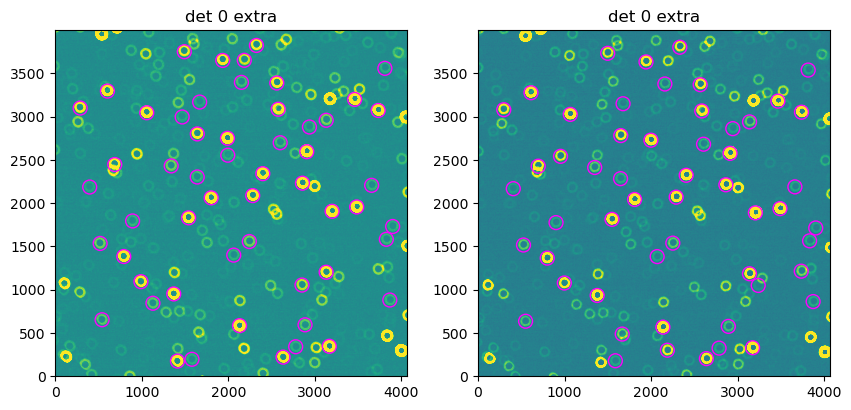

In [197]:
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,2,figsize=(10,5))
i=0
for exp, cat, title in zip([exp_intra, exp_extra], 
                                    [donutCatalogIntra, donutCatalogExtra], 
                                    ['intra', 'extra']
                                   ):
    d = exp.image.array
    vmin,vmax = zscale.get_limits(d)
    ax[i].imshow(d, vmin=vmin, vmax=vmax, origin='lower')
    
    ax[i].scatter(cat['centroid_x'], cat['centroid_y'], 
                marker='o', s=100, facecolors='none', edgecolors='magenta' 
                    )
    detId = refs[idx].dataId.detector.id
    ax[i].set_title(f'det {detId} extra')
    i +=1 

ok, so donuts got correctly detected. Do cutouts look ok?

Could do cutouts manually:

In [1]:
from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import (CutOutDonutsScienceSensorTask,
CutOutDonutsScienceSensorTaskConfig)
from lsst.obs.lsst import LsstComCam

camera = LsstComCam.getCamera()
config = CutOutDonutsScienceSensorTaskConfig()
task = CutOutDonutsScienceSensorTask(config=config)

In [201]:
exp_intra.visitInfo.focusZ

0.0

Both exposures have `visitInfo.focusZ` as `0.0` (!) So there's no way that this could work.... 

In [202]:
exp_intra.visitInfo.focusZ = -1.5
exp_extra.visitInfo.focusZ = 1.5

AttributeError: property of 'VisitInfo' object has no setter

In [198]:
taskOut = task.run([exp_intra, exp_extra],[donutCatalogIntra, donutCatalogExtra], camera)

ValueError: Must have one extra-focal and one intra-focal image.

No cutouts at all! Run a test with just 2 states:


pipetask run -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_direct_stamps_6001_test2  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDirectCutoutOnly.yaml -d "instrument='LSSTComCam' and exposure.seq_num = 6001" 


In [175]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutCatalog', 
           collections=['WET-001_lsstComCam_direct_stamps_6001_test2']).expanded()
for ref in dataRefs:
    print(ref)

donutCatalog@{instrument: 'LSSTComCam', detector: 0, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=1e855dee-7520-4651-949c-ec1f4503d070)
donutCatalog@{instrument: 'LSSTComCam', detector: 1, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=64235570-22fc-40a1-a757-b3b42e079bcc)
donutCatalog@{instrument: 'LSSTComCam', detector: 2, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=a287e722-3cc2-4acd-9f86-5cacffd6ae75)
donutCatalog@{instrument: 'LSSTComCam', detector: 3, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=ccc62341-9270-4e3c-93a4-ad98fb

In [181]:
#butler.registry.queryDatasetTypes()

In [182]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutStampsIntra', 
           collections=['WET-001_lsstComCam_direct_stamps_6001_test2'],
                                        where=f"instrument='LSSTComCam'").expanded()
for ref in dataRefs:
    print(ref)

In [169]:
datarefs = butler.registry.queryDatasets('donutStampsIntra', 
                              collections=['WET-001_lsstComCam_direct_stamps_6001_6200'],
where=f"instrument='LSSTComCam'"
                             ).expanded()
refs = []
for ref in datarefs:
   refs.append(ref)

print(len(refs))

0


Nothing! How is that possible? 

In [162]:
donutStampsExtra= butler.get('donutStampsIntra',dataId=dataId, 
                             collections=['WET-001_lsstComCam_direct_stamps_6001_6200'])

DatasetNotFoundError: Dataset donutStampsIntra with data ID {instrument: 'LSSTComCam', detector: 0, visit: 5024072306002} could not be found in collections ['WET-001_lsstComCam_direct_stamps_6001_6200'].

In [ ]:
Run TIE and Danish us

In [ ]:
isrCollection =     "WET-001_lsstComCam_ISR"
cutoutsCollection = "WET-001_lsstComCam_direct_stamps"
tieCollection =     "WET-001_lsstComCam_direct_TIE"
danishCollection =  "WET-001_lsstComCam_direct_Danish"

isrYaml = "lsstComCamPipelineISR.yaml"
cutoutYaml = "lsstComCamPipelineDirectCutoutOnly.yaml"
danishYaml = "lsstComCamPipelineCalcDanishOnly.yaml"
tieYaml = "lsstComCamPipelineCalcTieOnly.yaml"

pathCwd = '/sdf/group/rubin/shared/scichris/DM-46763_WET-007'
isrYamlPath = os.path.join(pathCwd, isrYaml)
cutoutYamlPath = os.path.join(pathCwd, cutoutYaml)
danishYamlPath = os.path.join(pathCwd, danishYaml)
tieYamlPath = os.path.join(pathCwd, tieYaml)

cmdCutout = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {isrCollection},LSSTCam/calib/unbounded \
-o {cutoutsCollection}  -p {cutoutYamlPath}"

cmdDanish = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {danishCollection}  -p {danishYamlPath} "

cmdTie = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {tieCollection}  -p {tieYamlPath}"

print(cmdCutout, "\n")
print(cmdDanish, "\n")
print(cmdTie, "\n")
